<a href="https://colab.research.google.com/github/tfindiamooc/tfindiamooc.github.io/blob/master/colabs/extending_tf_keras_through_functional_APIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Setup
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

There are two ways to extend tf.keras API:
* Write custom layers and models through subclassing
* Write models using Keras functional API

## Functional APIs

The `tf.keras.Sequential` model is a simple stack of layers that cannot
represent arbitrary models. Use the
[Keras functional API](./functional.ipynb)
to build complex model topologies such as:

* Multi-input models,
* Multi-output models,
* Models with shared layers (the same layer called several times),
* Models with non-sequential data flows (e.g. residual connections).

Building a model with the functional API works like this:

1. A layer instance is callable and returns a tensor.
2. Input tensors and output tensors are used to define a `tf.keras.Model`
   instance.
3. This model is trained just like the `Sequential` model.

## Introduction

You're already familiar with the use of `keras.Sequential()` to create models.
The Functional API is a way to create models that is more flexible than `Sequential`:
it can handle models with non-linear topology, models with shared layers,
and models with multiple inputs or outputs.

It's based on the idea that a deep learning model
is usually a directed acyclic graph (DAG) of layers.
The Functional API a set of tools for **building graphs of layers**.

Consider the following model:

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: probability distribution over 10 classes)
```

It's a simple graph of 3 layers.

To build this model with the functional API,
you would start by creating an input node:

In [0]:
from tensorflow import keras
inputs = keras.Input(shape=(784,))

Here we just specify the shape of our data: 784-dimensional vectors.
Note that the batch size is always omitted, we only specify the shape of each sample.
For an input meant for images of shape `(32, 32, 3)`, we would have used:

In [0]:
img_inputs = keras.Input(shape=(32, 32, 3))

What gets returned, `inputs`, contains information about the shape and dtype of the
input data that you expect to feed to your model:

In [0]:
inputs.shape

TensorShape([None, 784])

In [0]:
inputs.dtype

tf.float32

You create a new node in the graph of layers by calling a layer on this `inputs` object:

In [0]:
from tensorflow.keras import layers

dense = layers.Dense(64, activation='relu')
x = dense(inputs)

The "layer call" action is like drawing an arrow from "inputs" to this layer we created.
We're "passing" the inputs to the `dense` layer, and out we get `x`.

Let's add a few more layers to our graph of layers:

In [0]:
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

At this point, we can create a `Model` by specifying its inputs and outputs in the graph of layers:

In [0]:
model = keras.Model(inputs=inputs, outputs=outputs)

To recap, here is our full model definition process:

In [0]:
inputs = keras.Input(shape=(784,), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

Let's check out what the model summary looks like:

In [0]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


We can also plot the model as a graph:

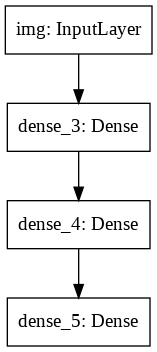

In [0]:
keras.utils.plot_model(model, 'my_first_model.png')

And optionally display the input and output shapes of each layer in the plotted graph:

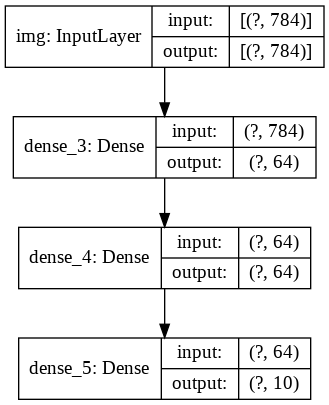

In [0]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)


This figure and the code we wrote are virtually identical. In the code version,
the connection arrows are simply replaced by the call operation.

A "graph of layers" is a very intuitive mental image for a deep learning model,
and the functional API is a way to create models that closely mirrors this mental image.

## Training, evaluation, and inference

Training, evaluation, and inference work exactly in the same way for models built
using the Functional API as for Sequential models.

Here is a quick demonstration.

Here we load MNIST image data, reshape it into vectors,
fit the model on the data (while monitoring performance on a validation split),
and finally we evaluate our model on the test data:

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 72us/sample - loss: 0.3361 - accuracy: 0.9035 - val_loss: 0.1736 - val_accuracy: 0.9510
Epoch 2/5
48000/48000 [==============================] - 3s 61us/sample - loss: 0.1594 - accuracy: 0.9524 - val_loss: 0.1478 - val_accuracy: 0.9577
Epoch 3/5
48000/48000 [==============================] - 3s 59us/sample - loss: 0.1175 - accuracy: 0.9645 - val_loss: 0.1180 - val_accuracy: 0.9652
Epoch 4/5
48000/48000 [==============================] - 3s 56us/sample - loss: 0.0926 - accuracy: 0.9728 - val_loss: 0.1113 - val_accuracy: 0.9673
Epoch 5/5
48000/48000 [==============================] - 3s 55us/sample - loss: 0.0782 - accuracy: 0.9772 - val_loss: 0.1121 - val_accuracy: 0.9677
Test loss: 0.105845703698555
Test accuracy: 0.9693


## Saving and serialization

Saving and serialization work exactly in the same way for models built
using the Functional API as for Sequential models.

To standard way to save a Functional model is to call `model.save()` to save the whole model into a single file.
You can later recreate the same model from this file, even if you no longer have access to the code
that created the model.

This file includes:
- The model's architecture
- The model's weight values (which were learned during training)
- The model's training config (what you passed to `compile`), if any
- The optimizer and its state, if any (this enables you to restart training where you left off)

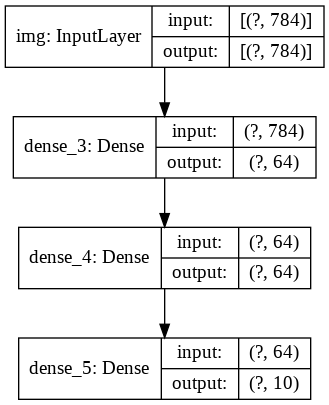

In [0]:
model.save('path_to_my_model.h5')
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model('path_to_my_model.h5')
keras.utils.plot_model(model, 'my_first_model_with_shape_info_reloaded.png', show_shapes=True)

## Using the same graph of layers to define multiple models


In the functional API, models are created by specifying their inputs
and outputs in a graph of layers. That means that a single graph of layers
can be used to generate multiple models.

In the example below, we use the same stack of layers to instantiate two models:
an `encoder` model that turns image inputs into 16-dimensional vectors,
and an end-to-end `autoencoder` model for training.

In [0]:
# First we define encoder model through keras functional API.
encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()
print ()

# Note: we use encoder_output as input here.
x = layers.Reshape((4, 4, 1))(encoder_output)

# Note: The reverse of a Conv2D layer is a Conv2DTranspose layer.
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)

# and the reverse of a MaxPooling2D layer is an UpSampling2D layer.
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

Note that we make the decoding architecture strictly symmetrical to the encoding architecture,
so that we get an output shape that is the same as the input shape `(28, 28, 1)`.
The reverse of a `Conv2D` layer is a `Conv2DTranspose` layer, and the reverse of a `MaxPooling2D`
layer is an `UpSampling2D` layer.

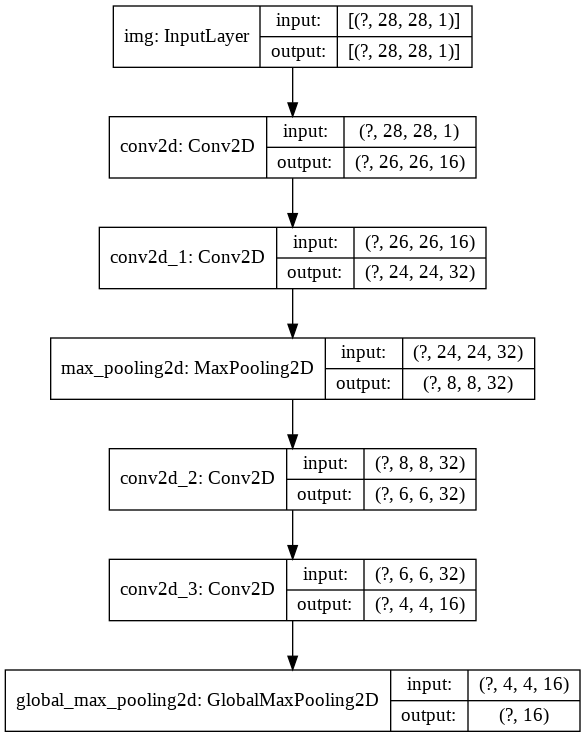

In [0]:
keras.utils.plot_model(encoder, 'encoder_model.png', show_shapes=True)

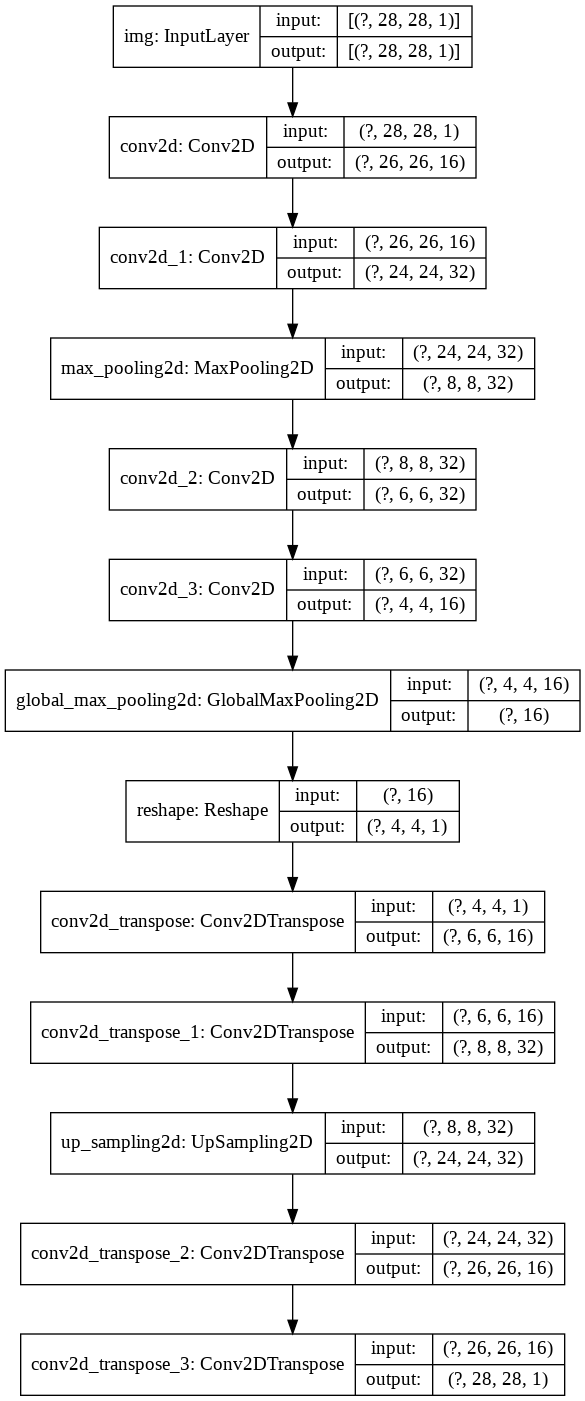

In [0]:
# Let's look at Autoencoder model
keras.utils.plot_model(autoencoder, 'autoencoder_model.png', show_shapes=True)


## All models are callable, just like layers

You can treat any model as if it were a layer, by calling it on an `Input` or on the output of another layer.
Note that by calling a model you aren't just reusing the architecture of the model, you're also reusing its weights.

Let's see this in action. Here's a different take on the autoencoder example that creates an encoder model, a decoder model,
and chain them in two calls to obtain the autoencoder model:

In [0]:
encoder_input = keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

As you can see, model can be nested: a model can contain submodels (since a model is just like a layer).

A common use case for model nesting is *ensembling*.
As an example, here's how to ensemble a set of models into a single model that averages their predictions:

In [0]:
def get_model():
  inputs = keras.Input(shape=(128,))
  outputs = layers.Dense(1, activation='sigmoid')(inputs)
  return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

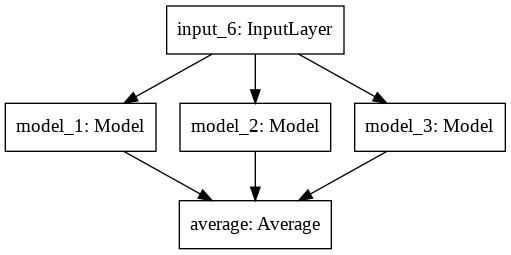

In [0]:
# Let's look at Autoencoder model
keras.utils.plot_model(ensemble_model, 'ensemble_model_model.png')

## Manipulating complex graph topologies


### Models with multiple inputs and outputs

The functional API makes it easy to manipulate multiple inputs and outputs.
This cannot be handled with the Sequential API.

Here's a simple example.

Let's say you're building a system for ranking custom issue tickets by priority and routing them to the right department.

You model will have 3 inputs:

- Title of the ticket (text input)
- Text body of the ticket (text input)
- Any tags added by the user (categorical input)

It will have two outputs:

- Priority score between 0 and 1 (scalar sigmoid output)
- The department that should handle the ticket (softmax output over the set of departments)

Let's built this model in a few lines with the Functional API.

In [0]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])

Let's plot the model

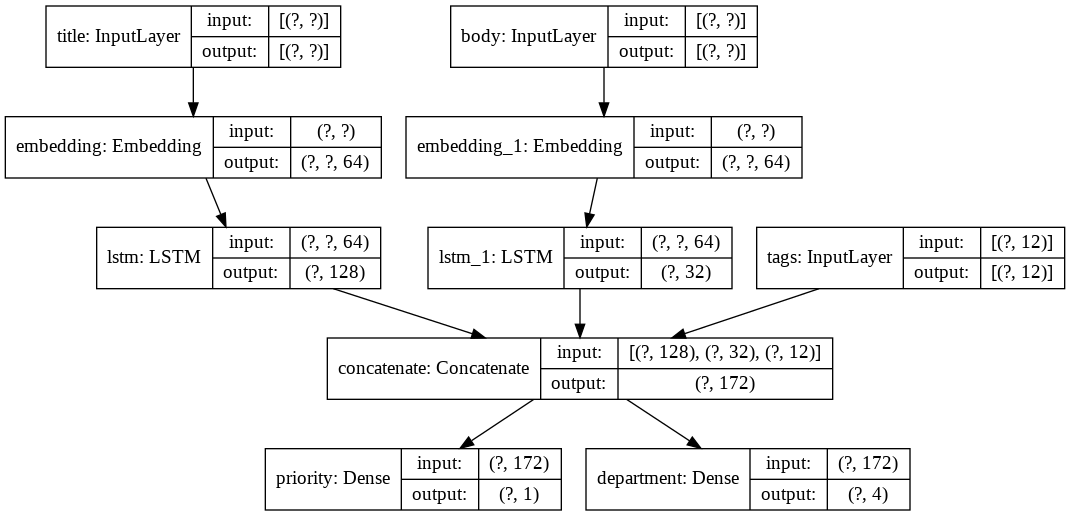

In [0]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

When compiling this model, we can assign different losses to each output. You can even assign different weights to each loss, to modulate their contribution to the total training loss.

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=['binary_crossentropy', 'categorical_crossentropy'],
              loss_weights=[1., 0.2])


Since we gave names to our output layers, we could also specify the loss like this:

In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'priority': 'binary_crossentropy',
                    'department': 'categorical_crossentropy'},
              loss_weights=[1., 0.2])

We can train the model by passing lists of Numpy arrays of inputs and targets:

In [0]:
import numpy as np

# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')
# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit({'title': title_data, 'body': body_data, 'tags': tags_data},
          {'priority': priority_targets, 'department': dept_targets},
          epochs=2,
          batch_size=32)

Train on 1280 samples
Epoch 1/2
1280/1280 [==============================] - 7s 6ms/sample - loss: 1.3060 - priority_loss: 0.7043 - department_loss: 3.0088
Epoch 2/2
1280/1280 [==============================] - 3s 2ms/sample - loss: 1.3000 - priority_loss: 0.6970 - department_loss: 3.0150


When calling fit with a `Dataset` object, it should yield either a
tuple of lists like `([title_data, body_data, tags_data], [priority_targets, dept_targets])`
or a tuple of dictionaries like
`({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`.

### A toy resnet model

In addition to models with multiple inputs and outputs,
the Functional API makes it easy to manipulate non-linear connectivity topologies,
that is to say, models where layers are not connected sequentially.
This also cannot be handled with the Sequential API (as the name indicates).

A common use case for this is residual connections.

Let's build a toy ResNet model for CIFAR10 to demonstrate this.

In [0]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

# Note non-linear connection here.
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

# Note non-linear connection here.
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='toy_resnet')
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_________________________________________________________________________________________

Let's plot the model:

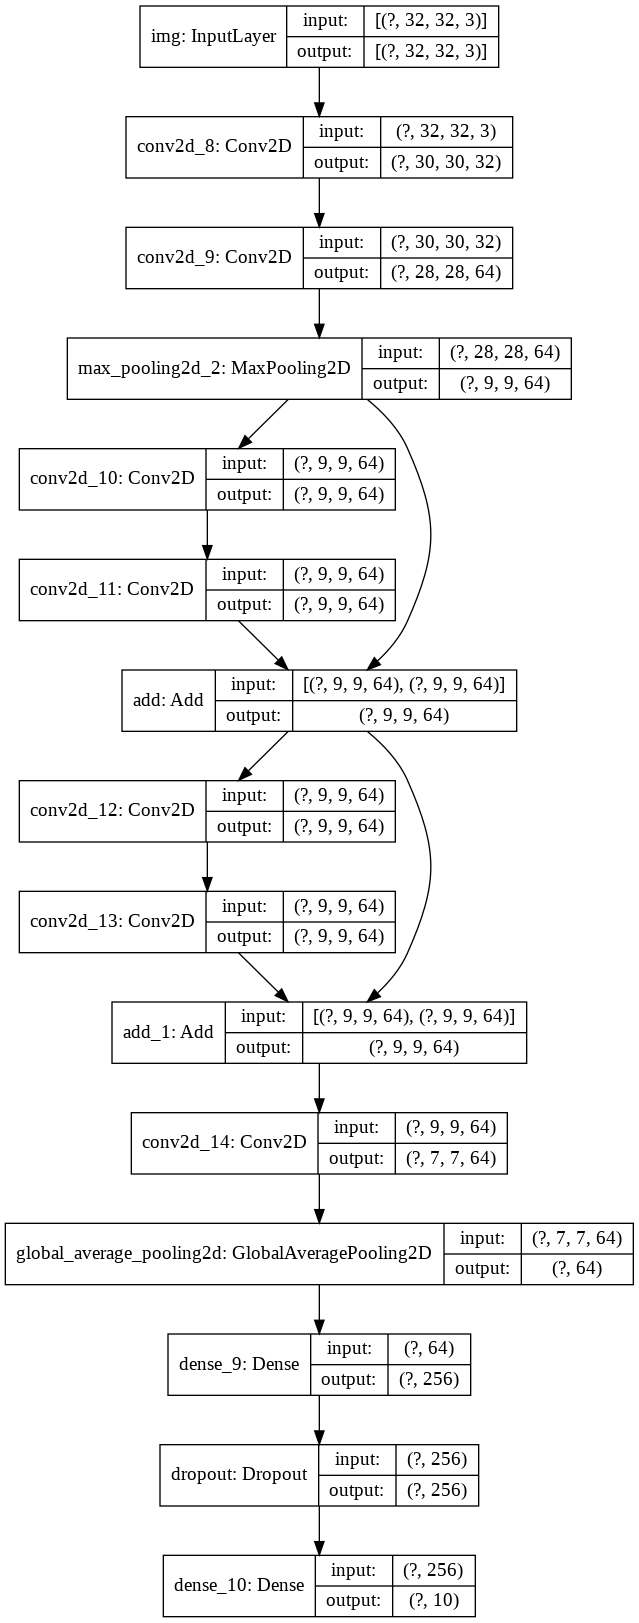

In [0]:
keras.utils.plot_model(model, 'mini_resnet.png', show_shapes=True)

Let's train it:

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 249s 6ms/sample - loss: 1.9158 - acc: 0.2749 - val_loss: 1.6946 - val_acc: 0.3804


## Sharing layers

Another good use for the functional API are models that use shared layers. Shared layers are layer instances that get reused multiple times in a same model: they learn features that correspond to multiple paths in the graph-of-layers.

Shared layers are often used to encode inputs that come from similar spaces (say, two different pieces of text that feature similar vocabulary), since they enable sharing of information across these different inputs, and they make it possible to train such a model on less data. If a given word is seen in one of the inputs, that will benefit the processing of all inputs that go through the shared layer.

To share a layer in the Functional API, just call the same layer instance multiple times. For instance, here's an `Embedding` layer shared across two different text inputs:

In [0]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype='int32')

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype='int32')

# We reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## Extracting and reusing nodes in the graph of layers

Because the graph of layers you are manipulating in the Functional API is a static datastructure, it can be accessed and inspected. This is how we are able to plot Functional models as images, for instance.

This also means that we can access the activations of intermediate layers ("nodes" in the graph) and reuse them elsewhere. This is extremely useful for feature extraction, for example!

Let's look at an example. This is a VGG19 model with weights pre-trained on ImageNet:

In [0]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19()

And these are the intermediate activations of the model, obtained by querying 
the graph datastructure:

In [0]:
features_list = [layer.output for layer in vgg19.layers]

We can use these features to create a new feature-extraction model, that returns the values of the intermediate layer activations -- and we can do all of this in 3 lines.

In [0]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype('float32')
extracted_features = feat_extraction_model(img)


## Extending the API by writing custom layers

tf.keras has a wide range of built-in layers. Here are a few examples:

- Convolutional layers: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranspose`, etc.
- Pooling layers: `MaxPooling1D`, `MaxPooling2D`, `MaxPooling3D`, `AveragePooling1D`, etc.
- RNN layers: `GRU`, `LSTM`, `ConvLSTM2D`, etc.
- `BatchNormalization`, `Dropout`, `Embedding`, etc.

If you don't find what you need, it's easy to extend the API by creating your own layers.

All layers subclass the `Layer` class and implement:
- A `call` method, that specifies the computation done by the layer.
- A `build` method, that creates the weights of the layer (note that this is just a style convention; you could create weights in `__init__` as well).

Here's a simple implementation of a `Dense` layer:

In [0]:
class CustomDense(layers.Layer):

  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

If you want your custom layer to support serialization, you should also define a get_config method, that returns the constructor arguments of the layer instance:

In [0]:
class CustomDense(layers.Layer):

  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

  def get_config(self):
    return {'units': self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(
    config, custom_objects={'CustomDense': CustomDense})

## When to use the Functional API

How to decide whether to use the Functional API to create a new model, or just subclass the `Model` class directly?

In general, the Functional API is higher-level, easier & safer to use, and has a number of features that subclassed Models do not support.

However, Model subclassing gives you greater flexibility when creating models that are not easily expressible as directed acyclic graphs of layers (for instance, you could not implement a Tree-RNN with the Functional API, you would have to subclass `Model` directly).


### Here are the strengths of the Functional API:

The properties listed below are all true for Sequential models as well (which are also data structures), but they aren't true for subclassed models (which are Python bytecode, not data structures).


#### It is less verbose.

No `super(MyClass, self).__init__(...)`, no `def call(self, ...):`, etc.

Compare:

```python
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)
```

With the subclassed version:

```python
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))
```


#### It validates your model while you're defining it.

In the Functional API, your input specification (shape and dtype) is created in advance (via `Input`), and every time you call a layer, the layer checks that the specification passed to it matches its assumptions, and it will raise a helpful error message if not.

This guarantees that any model you can build with the Functional API will run. All debugging (other than convergence-related debugging) will happen statically during the model construction, and not at execution time. This is similar to typechecking in a compiler.


#### Your Functional model is plottable and inspectable.

You can plot the model as a graph, and you can easily access intermediate nodes in this graph -- for instance, to extract and reuse the activations of intermediate layers, as we saw in a previous example:

```python
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
```


#### Your Functional model can be serialized or cloned.

Because a Functional model is a data structure rather than a piece of code, it is safely serializable and can be saved as a single file that allows you to recreate the exact same model without having access to any of the original code. See our [saving and serialization guide](./saving_and_serializing.ipynb) for more details.


### Here are the weaknesses of the Functional API:


#### It does not support dynamic architectures.

The Functional API treats models as DAGs of layers. This is true for most deep learning architectures, but not all: for instance, recursive networks or Tree RNNs do not follow this assumption and cannot be implemented in the Functional API.


#### Sometimes, you just need to write everything from scratch.

When writing advanced achitectures, you may want to do things that are outside the scope of "defining a DAG of layers": for instance, you may want to expose multiple custom training and inference methods on your model instance. This requires subclassing.


---


To dive more in-depth into the differences between the Functional API and Model subclassing, you can read [What are Symbolic and Imperative APIs in TensorFlow 2.0?](https://medium.com/tensorflow/what-are-symbolic-and-imperative-apis-in-tensorflow-2-0-dfccecb01021).

## Mix-and-matching different API styles

Importantly, choosing between the Functional API or Model subclassing isn't a binary decision that restricts you to one category of models. All models in the tf.keras API can interact with each, whether they're Sequential models, Functional models, or subclassed Models/Layers written from scratch.

You can always use a Functional model or Sequential model as part of a subclassed Model/Layer:

In [0]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):

  def __init__(self):
    super(CustomRNN, self).__init__()
    self.units = units
    self.projection_1 = layers.Dense(units=units, activation='tanh')
    self.projection_2 = layers.Dense(units=units, activation='tanh')
    
    # Our previously-defined Functional model
    self.classifier = model

  def call(self, inputs):
    outputs = []
    state = tf.zeros(shape=(inputs.shape[0], self.units))
    for t in range(inputs.shape[1]):
      x = inputs[:, t, :]
      h = self.projection_1(x)
      y = h + self.projection_2(state)
      state = y
      outputs.append(y)
    features = tf.stack(outputs, axis=1)
    print(features.shape)
    return self.classifier(features)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


Inversely, you can use any subclassed Layer or Model in the Functional API as long as it implements a `call` method that follows one of the following patterns:

- `call(self, inputs, **kwargs)`  where `inputs` is a tensor or a nested structure of tensors (e.g. a list of tensors), and where `**kwargs` are non-tensor arguments (non-inputs).
- `call(self, inputs, training=None, **kwargs)` where `training` is a boolean indicating whether the layer should behave in training mode and inference mode.
- `call(self, inputs, mask=None, **kwargs)` where `mask` is a boolean mask tensor (useful for RNNs, for instance).
- `call(self, inputs, training=None, mask=None, **kwargs)` -- of course you can have both masking and training-specific behavior at the same time.

In addition, if you implement the `get_config` method on your custom Layer or Model, the Functional models you create with it will still be serializable and clonable.

Here's a quick example where we use a custom RNN written from scratch in a Functional model:

In [0]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):

  def __init__(self):
    super(CustomRNN, self).__init__()
    self.units = units
    self.projection_1 = layers.Dense(units=units, activation='tanh')
    self.projection_2 = layers.Dense(units=units, activation='tanh')
    self.classifier = layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    outputs = []
    state = tf.zeros(shape=(inputs.shape[0], self.units))
    for t in range(inputs.shape[1]):
      x = inputs[:, t, :]
      h = self.projection_1(x)
      y = h + self.projection_2(state)
      state = y
      outputs.append(y)
    features = tf.stack(outputs, axis=1)
    return self.classifier(features)

# Note that we specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when we create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))

Now you have at your fingertips a powerful set of tools for building deep learning models.